In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)


# New Section

In [12]:
import pandas as pd
import numpy as np

# Load data from CSV into a pandas DataFrame
df = pd.read_csv('/content/sunspotedit.csv')

# Extract numeric columns for normalization
numeric_cols = ['Temp']

# Convert 'Temp' column to numeric if needed (handle any non-numeric values gracefully)
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')

# Define min-max normalization function
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

# Normalize the numeric data
df['Temp'] = min_max_normalize(df['Temp'])

# Print normalized DataFrame
print(df)

# Optionally, save normalized data back to CSV
df.to_csv('sunspotnorm.csv', index=False)
TEMPERATURES_CSV='sunspotnorm.csv'

             Date     Temp
0      1818-01-01  0.00000
1      1818-01-02  0.00000
2      1818-01-03  0.00000
3      1818-01-04  0.00000
4      1818-01-05  0.00000
...           ...      ...
73713  2019-10-27  0.00189
73714  2019-10-28  0.00189
73715  2019-10-29  0.00189
73716  2019-10-30  0.00189
73717  2019-10-31  0.00189

[73718 rows x 2 columns]


In [13]:
with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

Date,Temp

First data point looks like this:

1818-01-01,0.0

Second data point looks like this:

1818-01-02,0.0



In [14]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [15]:
def parse_data_from_file(filename):

    times = []
    temperatures = []

    with open(filename) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            temperatures.append(float(row[1]))
            times.append(row[0])

    return times, temperatures

In [16]:
@dataclass
class G:

    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    time_series = np.array(parse_data_from_file(TEMPERATURES_CSV))
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


In [17]:

def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

In [18]:

def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [19]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [20]:
def compute_metrics(true_series, forecast):

    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

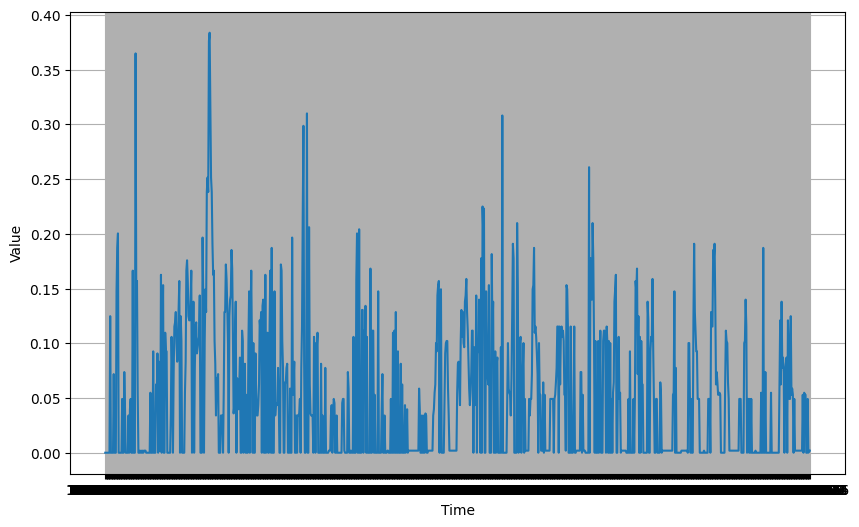

In [21]:
subset_size = 1000  # Adjust this number to plot more or fewer points
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES, start=0, end=subset_size)
plt.show()

In [22]:
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)
dataset = windowed_dataset(series_train)


In [23]:
model_tune = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[G.WINDOW_SIZE], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [24]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)


In [25]:
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0047 - lr: 1.0000e-08
Epoch 2/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0047 - lr: 1.1220e-08
Epoch 3/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0047 - lr: 1.2589e-08
Epoch 4/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0047 - lr: 1.4125e-08
Epoch 5/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0047 - lr: 1.5849e-08
Epoch 6/100
77/77 [==============================] - 1s 8ms/step - loss: 0.0047 - lr: 1.7783e-08
Epoch 7/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0047 - lr: 1.9953e-08
Epoch 8/100
77/77 [==============================] - 1s 10ms/step - loss: 0.0047 - lr: 2.2387e-08
Epoch 9/100
77/77 [==============================] - 1s 13ms/step - loss: 0.0047 - lr: 2.5119e-08
Epoch 10/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0047 - lr: 2.8184e-08
Epoch 11/100
77/77 [=======

(1e-08, 0.001, 0.0, 300.0)

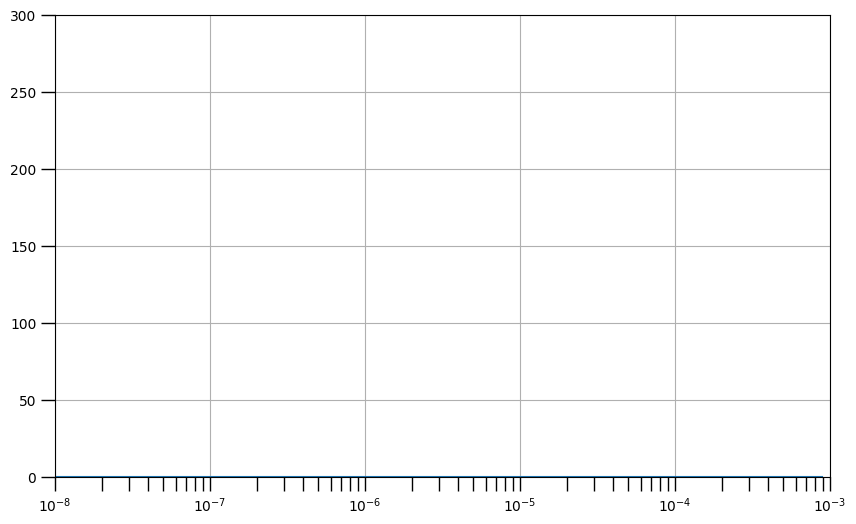

In [26]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

In [27]:
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[G.WINDOW_SIZE]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])


In [28]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)


In [29]:
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)


Epoch 1/100
77/77 [==============================] - 2s 13ms/step - loss: 0.0025
Epoch 2/100
77/77 [==============================] - 1s 12ms/step - loss: 0.0025
Epoch 3/100
77/77 [==============================] - 1s 11ms/step - loss: 0.0025
Epoch 4/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0024
Epoch 5/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0024
Epoch 6/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0024
Epoch 7/100
77/77 [==============================] - 1s 13ms/step - loss: 0.0024
Epoch 8/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0024
Epoch 9/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0024
Epoch 10/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0024
Epoch 11/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0024
Epoch 12/100
77/77 [==============================] - 1s 6ms/step - loss: 0.0024
Epoch 13/100
77/77 [=============

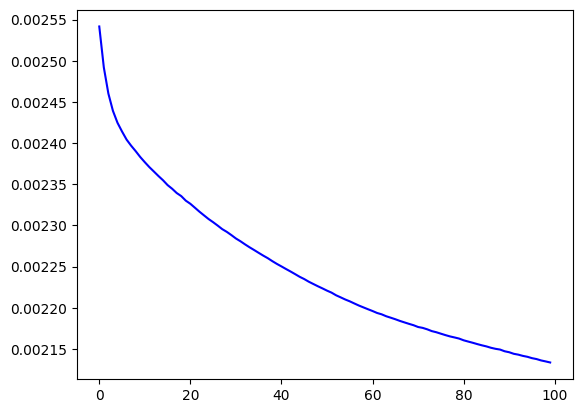

In [30]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

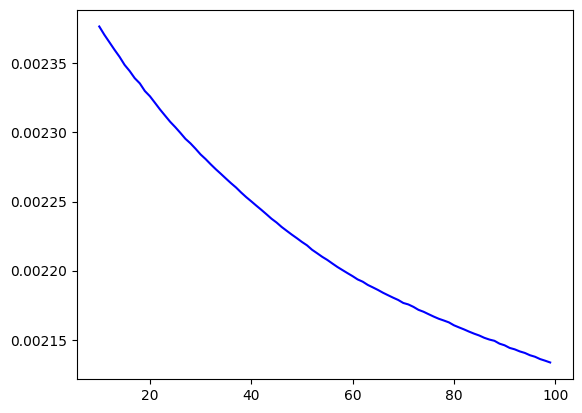

In [31]:
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

In [32]:
rnn_forecast = model_forecast(model_tune, G.SERIES, G.WINDOW_SIZE).squeeze()


2302/2302 [==============================] - 19s 8ms/step


In [33]:
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]


In [34]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")


mse: 0.02, mae: 0.11 for forecast
